##Deep Learning Model

Libraries

In [10]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np 
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import sklearn
from sklearn.model_selection import * # train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Build Model

In [51]:
def conv_block(inputs, num_filters): #2 convolution layers
	x = Conv2D(num_filters, 3, padding="same")(inputs)
	x = BatchNormalization()(x)
	x = Activation("relu")(x)
	
	x = Conv2D(num_filters, 3, padding="same")(x)
	x = BatchNormalization()(x)
	x = Activation("relu")(x)
	
	return x

def encoder_block(inputs, num_filters):
	x = conv_block(inputs, num_filters)
	p = MaxPool2D((2, 2))(x)
	return x, p

def decoder_block(inputs, skip_features, num_filters):
	x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
	x = Concatenate()([x, skip_features]) #x and skip features same dimension
	x = conv_block(x, num_filters)
	return x
	
def build_unet(input_shape):
	inputs = Input(input_shape)
	#Encoder (4 blocks)
	s1, p1 = encoder_block(inputs, 64)
	s2, p2 = encoder_block(p1, 128)
	s3, p3 = encoder_block(p2, 265)
	s4, p4 = encoder_block(p3, 512)
	
	#bridge
	b1 = conv_block(p4, 1024)
	
	#decoder
	d1 = decoder_block(b1, s4, 512)
	d2 = decoder_block(d1, s3, 256)
	d3 = decoder_block(d2, s2, 128)
	d4 = decoder_block(d3, s1, 64)
	
	#output layer
	
	outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
	
	model = Model(inputs, outputs, name="U-Net")
	return model
	

input_shape = (512, 512, 3)
model = build_unet(input_shape)
model.summary()



Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 512, 512, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 512, 512, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                             

Data

In [52]:
def load_data(dataset_path):	
	images = sorted(glob(os.path.join(dataset_path, "images/*")))
	masks = sorted(glob(os.path.join(dataset_path, "masks/*")))
	# print(len(images))
	# print(len(masks))
	
	#splitting 20% of images/masks for testing and rest for training
	train_x, test_x = train_test_split(images, test_size=0.2, random_state=42)	#x for images
	train_y, test_y = train_test_split(masks, test_size=0.2, random_state=42)	#y for masks
	return (train_x, train_y), (test_x, test_y)

def read_image(path):
	x = cv2.imread(path, cv2.IMREAD_COLOR) #rgb image
	x = cv2.resize(x, (256, 256))
	x = x/255.0 # 0 and 1
	x = x.astype(np.float32)
	# 256, 256, 3
	return x
	
def read_mask(path):
	x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
	x = cv2.resize(x, (256, 256))
	x = x.astype(np.float32)
	# 256, 256 -> 256, 256, 1
	x = np.expand_dims(x, axis=-1)
	return x

def preprocess(image_path, mask_path):
	def f(image_path, mask_path):
		image_path = image_path.decode()
		mask_path = mask_path.decode()
		
		x = read_image(image_path)
		y = read_mask(mask_path)
		
		return x, y
	image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.float32])
	image.set_shape([256, 256, 3])
	mask.set_shape([256, 256, 1])
	return image, mask
	
def tf_dataset(images, masks, batch=8):
	dataset = tf.data.Dataset.from_tensor_slices((images, masks))
	dataset = dataset.shuffle(buffer_size=5000)
	dataset = dataset.map(preprocess)
	dataset = dataset.batch(batch)
	dataset = dataset.prefetch(2)
	return dataset


dataset_path = "/content/drive/MyDrive/image_project/people_segmentation/"
images = glob(os.path.join(dataset_path, "images/*"))
masks = glob(os.path.join(dataset_path, "masks/*"))

(train_x, train_y), (test_x, test_y) = load_data(dataset_path)
print("train_x train_y")
print(len(train_x), len(train_y))
print("test_x test_y")
print(len(test_x), len(test_y))

# 	x = read_image(train_x[0])	
# 	cv2.imwrite("./1.png", x*255) #undo normalization
# 	y = read_mask(train_y[0])
# 	cv2.imwrite("./2.png", y*255)

# train_dataset = tf_dataset(train_x, train_y, batch=12)
# for image, mask in train_dataset:
#     print(image.shape, mask.shape)
    
batch = 12
train_steps = len(train_x)//batch
if len(train_x) % batch != 0:
    train_steps += 1
print("Train Steps: ", train_steps)

train_x train_y
4520 4498
test_x test_y
1130 1125
Train Steps:  377


Train Model

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

dataset_path = "/content/drive/MyDrive/image_project/people_segmentation/"
#hyperparameters
input_shape = (256, 256, 3)
batch_size = 8
epochs = 2
lr = 1e-4
model_path = "/content/drive/MyDrive/image_project/unet.h5"
csv_path = "/content/drive/MyDrive/image_project/data.csv"

#loading dataset
(train_x, train_y), (test_x, test_y) = load_data(dataset_path)
train_x = train_x[:-22]
test_x = test_x[:-5]
print("Training:", len(train_x), len(train_y)) #first test
print("Testing:", len(test_x), len(test_y))
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(test_x, test_y, batch=batch_size)

#Model
model = build_unet(input_shape)
model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(lr),
    metrics = [
        tf.keras.metrics.MeanIoU(num_classes=2), 
        tf.keras.metrics.Recall(), 
        tf.keras.metrics.Precision()
    ]
)
#model.summary()

callbacks = [
    ModelCheckpoint(model_path, monitor="val_loss", verbose=1),
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
    CSVLogger(csv_path), 
    EarlyStopping(monitor="val_loss", patience=10)
]

train_steps = len(train_x)//batch_size
if len(train_x) % batch != 0:
    train_steps += 1

valid_steps = len(test_x)//batch_size
if len(test_x) % batch_size != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Training: 4498 4498
Testing: 1125 1125
Epoch 1/2
563/563 [==============================] - ETA: 0s - loss: 0.5394 - mean_io_u: 0.3724 - recall: 0.1028 - precision: 0.3861
Epoch 1: saving model to ./unet.h5
563/563 [==============================] - 1579s 3s/step - loss: 0.5394 - mean_io_u: 0.3724 - recall: 0.1028 - precision: 0.3861 - val_loss: 0.5050 - val_mean_io_u: 0.3729 - val_recall: 0.3274 - val_precision: 0.4708 - lr: 1.0000e-04
Epoch 2/2
563/563 [==============================] - ETA: 0s - loss: 0.4932 - mean_io_u: 0.3724 - recall: 0.2145 - precision: 0.4978
Epoch 2: saving model to ./unet.h5
563/563 [==============================] - 303s 538ms/step - loss: 0.4932 - mean_io_u: 0.3724 - recall: 0.2145 - precision: 0.4978 - val_loss: 0.5075 - val_mean_io_u: 0.3729 - val_recall: 0.0459 - val_precision: 0.5015 - lr: 1.0000e-04


Test Model

In [15]:

test_images = glob("/content/drive/MyDrive/image_project/images/*")

model = tf.keras.models.load_model("/content/drive/MyDrive/image_project/unet.h5")

for path in tqdm(test_images, total=len(test_images)):
	x = cv2.imread(path, cv2.IMREAD_COLOR)
	original_image = x
	h, w, _ = x.shape
	
	x = cv2.resize(x, (256, 256))
	x = x/255.0
	x = x.astype(np.float32)
	# 256, 256, 3 --> 1, 256, 256, 3 batch format
	
	x = np.expand_dims(x, axis=0)
	
	pred_mask = model.predict(x)
	# 1, 256, 256 1 -> 256, 256, 1
	pred_mask = pred_mask[0]
	# 256, 256, 3
	
	pred_mask = np.concatenate(
		[pred_mask, pred_mask, pred_mask],
		axis=2
	)
	
	pred_mask = (pred_mask > 0.5) * 255 # 0 or 255
	pred_mask = pred_mask.astype(np.float32)
	pred_mask = cv2.resize(pred_mask, (w, h))
	
	original_image = original_image.astype(np.float32)
	
	alpha = 0.6
	cv2.addWeighted(pred_mask, alpha, original_image, 1-alpha, 0, original_image)
	
	#images/1.png
	
	name = path.split("/")[-1] # ["images", "1.png"]
	cv2.imwrite("/content/drive/MyDrive/image_project/save_images/" + name, original_image)
	# cv2.imshow(f"/content/drive/MyDrive/image_project/save_images/{name}")

  0%|          | 0/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 369ms/step


 25%|██▌       | 1/4 [00:00<00:01,  1.90it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 2/4 [00:00<00:00,  2.17it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 3/4 [00:01<00:00,  2.26it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


##Graph Based

Libraries

In [39]:
import cv2
import numpy as np
import sys

Building Methods

In [40]:
# This class contains all the required methods
class GraphSegmentation:
    def __init__(self):
        # Here we are creating a dictionary that store 1-D to 2-D index mapping
        # ex: 0 -> (0, 0) or 12 -> (3, 4)
        # It is helpful when we convert graph back to image
        self.vertex_to_img = {}

    def gaussian_filter(self, img, ksize, sigma):
        # Here we are creating gaussian kernel and then using convolution to smooth out the image.
        nimage = np.float64(img)
        kpad = int((ksize-1)/2)
        # Here we are creating a gaussian kernel of size (ksize x ksize)
        kernel = np.zeros((ksize, ksize), dtype='float64')
        # Here we are using loop to apply convolution
        for i in range(ksize):
            for j in range(ksize):
                kernel[i, j] = ( 1/np.sqrt(2*np.pi*(sigma**2)) ) * np.exp(- ( ( ((i-kpad)**2) + ((j-kpad)**2) )/( 2*(sigma**2) ) ) )
        ksum = np.sum(kernel)
        kernel /= ksum
        blur_image = cv2.filter2D(nimage, -1, kernel)
        return np.uint8(blur_image)

    def image_to_grid_graph(self, img):
        # We are using this method for Image To Graph Conversion
        img = np.int64(img)
        height, width = img.shape
        # This list store all the nodes and there connected neighbour node
        G = []
        # This list store all the edges of the graph along with their weights
        E = []
        # Using this loop we iterate over each pixel and convert it to a node.
        for row in range(height):
            for col in range(width):
                # Here we are doing book-keeping we store each row major order index along with its 2D index
                self.vertex_to_img[row*width+col] = (row, col)
                # Here we are calling a method to find neighbour of any pixel
                G, E = self.check_8_neigh(G, E, row, col, height, width, img)
        # This method is returnig a Adjacency List Graph and Edge List Graph
        return np.array(G), np.array(E)

    def check_8_neigh(self, G, E, row, col, height, width, img):
        # We are using this method for checking 8-neighbour connectivity
        # 1. We check boundary conditions.
        # 2. We calculate edge weight, which is difference between current pixel 
        #    intensity and neighbour pixel intensity
        # 3. We add neighbour node to adjacency list along with edge weight between them
        # 4. We add edge to Edge list.
        # This list store all the node connected to current node
        l = []
        if (row-1)>=0 and (col-1)>=0:
            w = abs(img[row, col]-img[row-1, col-1])
            l.append([(row-1)*width+(col-1), w])
            E.append([row*width+col , (row-1)*width+(col-1), w])
        if (row-1)>=0:
            w = abs(img[row, col]-img[row-1, col])
            l.append([(row-1)*width+col, w])
            E.append([row*width+col , (row-1)*width+col, w])
        if (row-1)>=0 and (col+1)<width:
            w = abs(img[row, col]-img[row-1, col+1])
            l.append([(row-1)*width+(col+1), w])
            E.append([row*width+col , (row-1)*width+(col+1), w])
        if (col-1)>=0:
            w = abs(img[row, col]-img[row, col-1])
            l.append([row*width+(col-1), w])
            E.append([row*width+col , row*width+(col-1), w])
        if (col+1)<width:
            w = abs(img[row, col]-img[row, col+1])
            l.append([row*width+(col+1), w])
            E.append([row*width+col , row*width+(col+1), w])
        if (row+1)<height and (col-1)>=0:
            w = abs(img[row, col]-img[row+1, col-1])
            l.append([(row+1)*width+(col-1), w])
            E.append([row*width+col , (row+1)*width+(col-1), w])
        if (row+1)<height:
            w = abs(img[row, col]-img[row+1, col])
            l.append([(row+1)*width+col, w])
            E.append([row*width+col , (row+1)*width+col, w])
        if (row+1)<height and (col+1)<width:
            w = abs(img[row, col]-img[row+1, col+1])
            l.append([(row+1)*width+(col+1), w])
            E.append([row*width+col , (row+1)*width+(col+1), w])
        G.append(l)
        return G, E

    def find_comp(self, S, node):
        # This method is used to find parent node of each connected component
        # Here Path Compression algorithm is also used
        while node!=S[node]:
            S[node] = S[S[node]]
            node = S[node]
        return S, node
    
    def build_mst(self, G, E):
        # We are using this method to build Minimum spanning tree using image graph
        V =  G.shape[0]
        # This list store parent component of each node, Parent List
        S = []
        # We are using this list to store rank of each component which is part of 
        # building mst algorithm, in easy words it store how many nodes are present in
        # each connected component.
        R = []
        # This dictionary store minimum spanning tree build using image graph
        MST = {}
        # Here we are initalizing default values to each list
        # In begning each node is parent of itself and rank of each component is zero
        for i in range(V):
            S.append(i)
            R.append(0)
        # Here we are sorting edge list based on edge weight in ascending order
        E = sorted(E, key=lambda x: x[2], reverse=False)
        # This dictionary store connected component
        comp_di = {}
        # In this loop we are iterating over each edge and building MST
        for i,edge in enumerate(E):
            sys.stdout.write('\rbuilding mst : {0}%'.format(int((float(i)/len(E))*100)))
            u, v, w = edge
            # Here we are finding parent component of node u
            S, c1 = self.find_comp(S, u)
            # Here we are finding parent component of node v
            S, c2 = self.find_comp(S, v)
            # Here we are checking if parent component of both nodes are different or not
            # If not that means if we add this edge it will going to form loop but that is not
            # possible because we are building a tree and there is no loop in tree. So we are not
            # adding that edge to connected component dictionary.
            if c1!=c2:
                # Here we are checking if c1 node is present in MST or not
                if c1 in MST:
                    MST[c1].append((c2, w))
                else:
                    MST[c1] = [(c2, w)]
                # Here we are checking if c2 node is present in MST or not
                if c2 in MST:
                    MST[c2].append((c1, w))
                else:
                    MST[c2] = [(c1, w)]
                # Here we are managing rank of the each component 
                # this part we are using to make MST building efficient.
                if R[c2] > R[c1]:
                    S[c2] = c1
                elif R[c1] > R[c2]:
                    S[c1] = c2
                else:
                    S[c2] = c1
                    R[c1] += 1
        # Here we are returning builded MST
        return MST

    def seg_alogrithm(self, G, MST, E, K):
        # This is the method where main segmentation algorithm is implemented
        # In this method we are passing MST, Adjacency List Graph and Edge List Graph
        V =  G.shape[0]
        # This list store parent component of each node, Segment Set
        S = []
        # We are using this list to store rank of each component which is part of 
        # building mst algorithm, in easy words it store how many nodes are present in
        # each connected component.
        R = []
        # Here we are initalizing default values to each list
        # In begning each node is parent of itself and rank of each component is zero
        for i in range(V):
            S.append(i)
            R.append(0)
        # Here we are sorting edge list based on edge weight in descending order.
        # So that the edges with most weight present at top and it shows there is
        # high transition between pixel intensity
        E = sorted(E, key=lambda x: x[2], reverse=True)
        # This dictionary store connected component
        comp_di = {}
        # In this loop we are iterating over each edges and building different component 
        # based on the segmentation algorithm, in the end we have a segmented image graph
        for i,edge in enumerate(E):
            sys.stdout.write('\rsegmentation completed : {0}%'.format(int((float(i)/len(E))*100)))
            u, v, w = edge
            # Here we are finding parent component of node u
            S, c1 = self.find_comp(S, u)
            # Here we are finding parent component of node v
            S, c2 = self.find_comp(S, v)
            # Here we are checking if parent component of both nodes are different or not
            # If not that means if we add this edge it will going to form loop but that is not
            # possible because we are building a tree and there is no loop in tree. So we are not
            # adding that edge to connected component dictionary.
            if c1!=c2:
                # Here we are adding nodes to each component
                comp_di = self.build_comp(comp_di, c1, c2, u, v)
                # Here we are checking if both component contain only one node
                # then merge both to one component
                if c1 == u and c2 == v:
                    # Here we are using the same rank based algorithm for building
                    # segmentation tree
                    if R[c2] > R[c1]:
                        S[c2] = c1
                    elif R[c1] > R[c2]:
                        S[c1] = c2
                    else:
                        S[c2] = c1
                        R[c1] += 1
                # If anyone or both components not contain one node then we use
                # following algorithm based on paper
                else:
                    # Here we are calculating internal difference of component c1
                    idiff_c1 = self.internal_diff(MST, comp_di[c1])
                    # Here we are calculating internal difference of component c2
                    idiff_c2 = self.internal_diff(MST, comp_di[c2])
                    # Here we are calculating tou value for each component
                    tou_c1 = K/(len(comp_di[c1])+1)
                    tou_c2 = K/(len(comp_di[c2])+1)
                    # Here we are finding minimum of internal differences of component
                    mint = min(idiff_c1+tou_c1, idiff_c2+tou_c2)
                    # Here we check that if minimum internal difference is less than current edge weight
                    # then we merge two components because this edge contain low possibility of being border
                    # pixel between two components.
                    if w > mint:
                        if R[c2] > R[c1]:
                            # Here we are merging two components
                            S[c2] = c1
                        elif R[c1] > R[c2]:
                            # Here we are merging two components
                            S[c1] = c2
                        else:
                            # Here we are merging two components
                            S[c2] = c1
                            R[c1] += 1
        # Here we are returning segmented image tree
        return S
    
    def build_comp(self, comp_di, c1, c2, u, v):
        # This method we are using to add nodes to component
        # Here we are checking if node c1 present in component dictionary or not
        if c1 in comp_di:
            # If component present in the dictionary then we add nodes to this component
            temp = [u] + comp_di[u] if u in comp_di else []
            temp = list(set(temp))
            comp_di[c1].extend(temp)
        else:
            # If component not present in the dictionary then we create a list and append
            # it to the component.
            comp_di[c1] = [u] if c1 != u else []
        if c2 in comp_di:
            # If component present in the dictionary then we add nodes to this component
            temp = [v] + comp_di[v] if v in comp_di else []
            temp = list(set(temp))
            comp_di[c2].extend(temp)
        else:
            # If component not present in the dictionary then we create a list and append
            # it to the component.
            comp_di[c2] = [v] if c2 != v else []
        return comp_di
    
    def internal_diff(self, G, C):
        # This method we are using for calculating internal difference
        # Internal difference is that edge present in component have minimum weight
        # in comparision to all the other edges in component graph.
        maxw = 10e9
        for u in C:
            if u in G:
                for v in G[u]:
                    maxw = min(v[1], maxw)
        return maxw

In [41]:
def get_color(col_di, node):
    if node in col_di:
        return col_di, col_di[node]
    else:
        b = np.random.randint(0, 255)
        g = np.random.randint(0, 255)
        r = np.random.randint(0, 255)
        col_di[node] = (b, g, r)
        return col_di, col_di[node]

Main Method

In [42]:
graph_obj = GraphSegmentation()
# loading image in grayscale channel only
img = cv2.imread('/content/drive/MyDrive/image_project/images/person1.jpeg', 0)
img = cv2.resize(img, None, fx=0.7, fy=0.7)
# applying gaussian blur to image with kernel size 3 and sigma 0.8 as per paper
smooth_img = graph_obj.gaussian_filter(img, 3, 0.8)
# building graph from given image
print('[info] : building graph')
ch1_G, ch1_E = graph_obj.image_to_grid_graph(smooth_img)
print('[info] : building graph complete')

[info] : building graph
[info] : building graph complete


<ipython-input-40-4cec45aaa091>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(G), np.array(E)


In [43]:
#building mst from image graph
print('[info] : building mst')
MST = graph_obj.build_mst(ch1_G, ch1_E)
print('\n[info] : building mst complete')

[info] : building mst
building mst : 99%
[info] : building mst complete


In [44]:
#applying segmentation algorithm on image graph
print('[info] : applying sementation')
S = graph_obj.seg_alogrithm(ch1_G, MST, ch1_E, 300)
print('\n[info] : segmentation complete')

[info] : applying sementation
segmentation completed : 99%
[info] : segmentation complete


In [45]:
#creating a blank image to store segmented components of image
seg_img = np.zeros((smooth_img.shape[0], smooth_img.shape[1], 3), dtype='uint8')
col_di = {} # Segment Color Dictionary
group_di = {} # Group Dictionary
print(seg_img.shape)

(136, 181, 3)


In [46]:
#creating a component list, so that all the nodes from same component must present in same list
for u, v in enumerate(S):
    u_row, u_col = graph_obj.vertex_to_img[u]
    S, par_v = graph_obj.find_comp(S, v)
    if par_v not in group_di:
        group_di[par_v] = [(u_row, u_col)]
    else:
        group_di[par_v].append((u_row, u_col))

In [47]:
'''
merging small components into one which is idea from selective search algorithm, 
node count as merging criteria. 
merging all those region or component which have number of nodes less than 5000.
'''
color_coord_list = []
temp_list = []
for key in group_di:
    if len(group_di[key]) <=5000:
        temp_list.extend(group_di[key])
    else:
        color_coord_list.append(temp_list)
        temp_list = []
        color_coord_list.append(group_di[key])
color_coord_list.append(temp_list)

In [48]:
#assiging colors to each region or component of segmented image
for coord_list in color_coord_list:
    b = np.random.randint(0, 255)
    g = np.random.randint(0, 255)
    r = np.random.randint(0, 255)
    col = (b, g, r)
    for item in coord_list:
        seg_img[item[0], item[1], :] = col

In [49]:
# seg_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2GRAY)
cv2.imwrite('/content/drive/MyDrive/image_project/output_graph_based/person1.jpeg', seg_img)

True

##Comparison

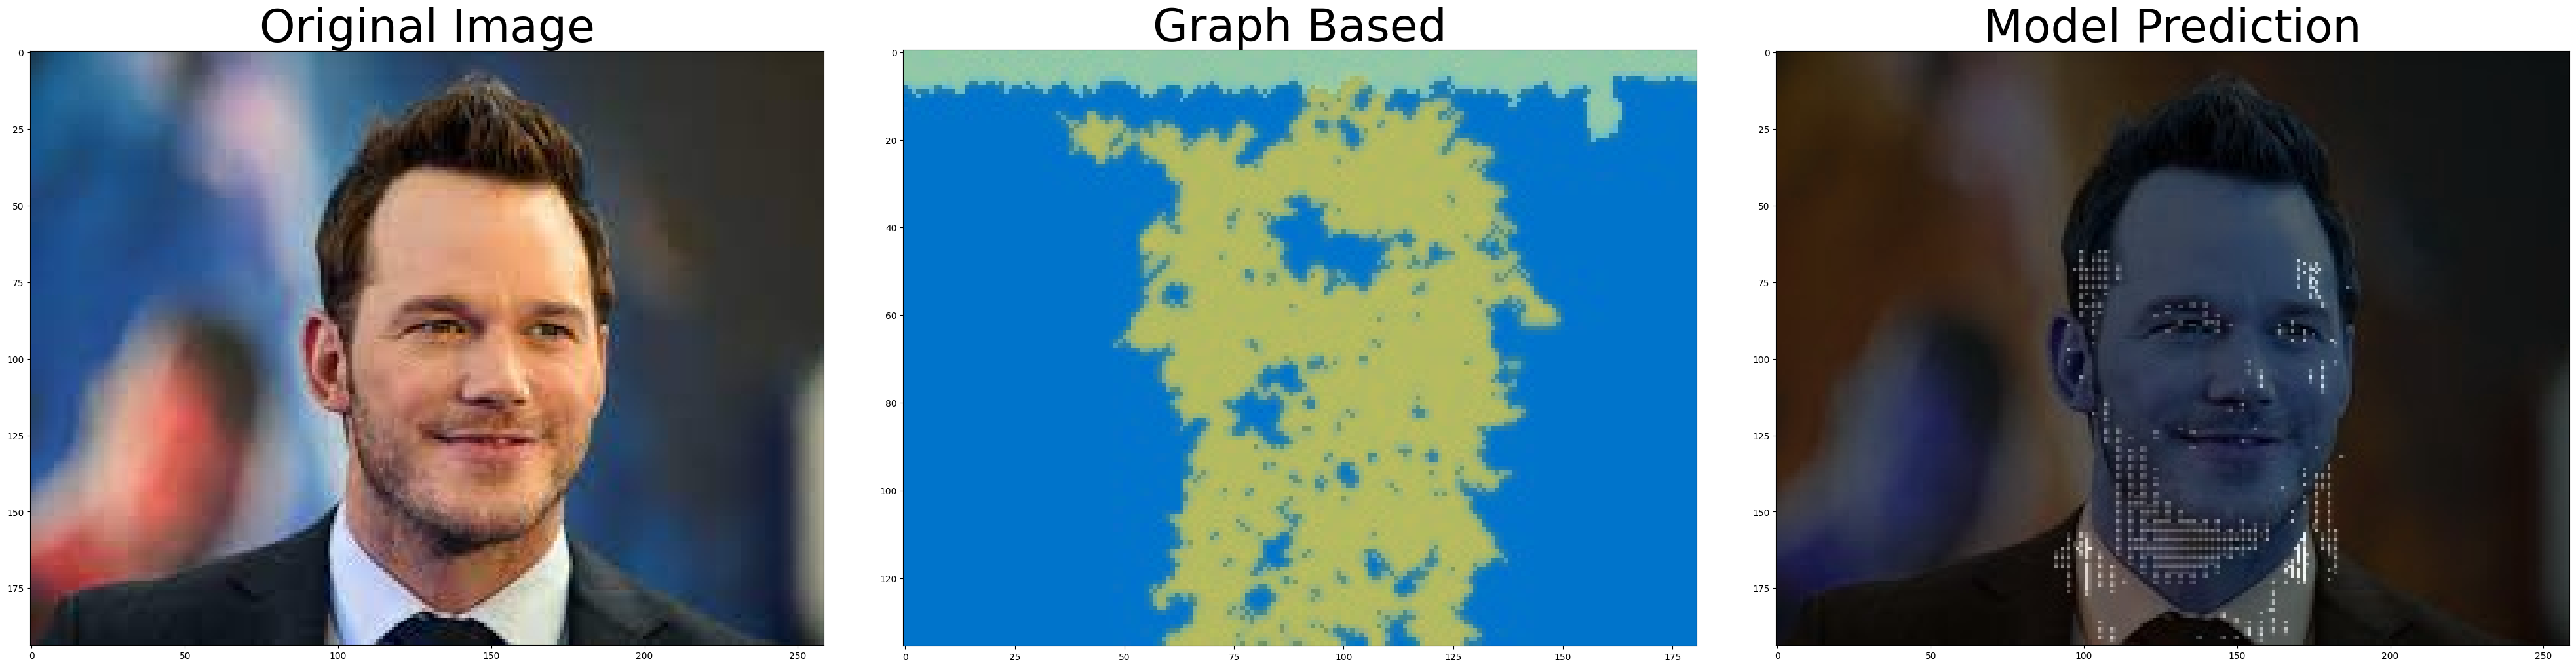

In [50]:
import matplotlib.pyplot as plt
import cv2

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(50, 25))

im = cv2.imread('/content/drive/MyDrive/image_project/images/person1.jpeg', cv2.IMREAD_COLOR)
org = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
graph = cv2.imread('/content/drive/MyDrive/image_project/output_graph_based/person1.jpeg', cv2.IMREAD_COLOR)
mod = cv2.imread('/content/drive/MyDrive/image_project/save_images/person1.jpeg', cv2.IMREAD_COLOR)

ax[0].imshow(org)
ax[0].set_title('Original Image', fontsize=50)

ax[1].imshow(graph)
ax[1].set_title('Graph Based', fontsize=50)

ax[2].imshow(mod)
ax[2].set_title('Model Prediction', fontsize=50)

plt.subplots_adjust(wspace=0.1)

plt.show()